### **Download the Data**
Let's download the data, I am using the raw campus data (2011_09_28_drive_0038_sync).

This data is synced and rectified, which is very important for this excercise


In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0038/2011_09_28_drive_0038_sync.zip

--2024-05-18 03:12:14--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0038/2011_09_28_drive_0038_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.10, 3.5.136.34, 52.219.169.189, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451849097 (431M) [application/zip]
Saving to: ‘2011_09_28_drive_0038_sync.zip.1’

2011_09_28_drive_00 100%[===================>] 430.92M  21.7MB/s    in 32s     

2024-05-18 03:12:46 (13.7 MB/s) - ‘2011_09_28_drive_0038_sync.zip.1’ saved [451849097/451849097]



And now we will download the corresponding calibration file which contains several transformation matrices that we will need

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_calib.zip

--2024-05-18 03:12:46--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.117, 52.219.47.27, 52.219.47.211, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4073 (4.0K) [application/zip]
Saving to: ‘2011_09_28_calib.zip.1’

2011_09_28_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2024-05-18 03:12:47 (78.4 MB/s) - ‘2011_09_28_calib.zip.1’ saved [4073/4073]



In [3]:
!jar xf 2011_09_28_drive_0038_sync.zip
!jar xf 2011_09_28_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS/IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

### **Base Library Import**

In [4]:
import os
from glob import glob
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [5]:
DATA_PATH = r'2011_09_28/2011_09_28_drive_0038_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 110
Number of right images: 110
Number of LiDAR point clouds: 110
Number of GPS/IMU frames: 110


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and translation matrix for LiDAR to camera frame of reference.


In [6]:
with open('2011_09_28/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

In [7]:
def decompose_projection_matrix(P):
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [8]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K)
 - The rotation Matrix (R)
 - The translation Matrix (T)

The rectified Rotation matrices will be used to help transform a LiDAR point to the camera frame of reference.

## **Load LiDAR and GPS/IMU Calibration Data**

In [9]:
with open(r'2011_09_28/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

In [10]:
with open(r'2011_09_28/calib_imu_to_velo.txt', 'r') as f:
    calib = f.readlines()

R_imu_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_imu_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_imu_velo = np.vstack((np.hstack((R_imu_velo, t_imu_velo)),
                        np.array([0, 0, 0, 1])))

Obtain matrix to transform 3D LiDAR/velo (x, y, z) coordiantes to 2D camera (u,v) coordinates, and it's homogeneous inverse that will allow us to transform from camera (u, v, z, 1) back to LiDAR (x, y, z, 1)

In [11]:
# matrix to transform from velo (LiDAR) to left color camera (shape 3x4)
T_mat = P_left @ R_left_rect @ T_ref0_ref2 @ T_cam_velo

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_homo = np.linalg.inv(np.insert(T_mat, 3, values=[0,0,0,1], axis=0))

Now we can get the transformation matrix for IMU to camera and camera to IMU

In [12]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam = T_mat @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam_imu = np.linalg.inv(np.insert(T_imu_cam, 3, values=[0,0,0,1], axis=0))

### **Create LiDAR points pipeline**

We will read in the LiDAR point clouds and transform them to the image plane. The code is partially based on the this [repository](https://github.com/azureology/kitti-velo2cam). Once again the information for the calibration parameters is located [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

In [13]:
def velo2camera(velo_points, image=None, remove_outliers=True):
    ''' maps velo points (LiDAR) to camera (u,v,z) space '''
    # convert to (left) camera coordinates
    # P_left @ R_left_rect @ T_cam_velo
    velo_camera =  T_mat @ velo_points

    # delete negative camera points
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1)

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    # remove outliers (points outside of the image frame)
    if remove_outliers:
        u, v, z = velo_camera
        img_h, img_w, _ = image.shape
        u_out = np.logical_or(u < 0, u > img_w)
        v_out = np.logical_or(v < 0, v > img_h)
        outlier = np.logical_or(u_out, v_out)
        velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera

In [14]:
from sklearn import linear_model

def bin2h_velo(lidar_bin, remove_plane=True):
    ''' Reads LiDAR bin file and returns homogeneous (x,y,z,1) LiDAR points'''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # get x,y,z LiDAR points (x, y, z) --> (front, left, up)
    velo_points = scan_data[:, 0:3]

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1)

    # use ransac to remove ground plane
    if remove_plane:
            ransac = linear_model.RANSACRegressor(
                                          linear_model.LinearRegression(),
                                          residual_threshold=0.1,
                                          max_trials=5000
                                          )

            X = velo_points[:, :2]
            y = velo_points[:, -1]
            ransac.fit(X, y)


            # remove outlier points
            mask = ransac.inlier_mask_
            velo_points = velo_points[~mask]

    # homogeneous LiDAR points
    velo_points = np.insert(velo_points, 3, 1, axis=1).T

    return velo_points

In [15]:
def project_velo2cam(lidar_bin, image, remove_plane=True):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get homogeneous LiDAR points from binn file
    velo_points = bin2h_velo(lidar_bin, remove_plane)

    # get camera (u, v, z) coordinates
    velo_camera = velo2camera(velo_points, image, remove_outliers=True)

    return velo_camera

In [16]:
index = 75

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

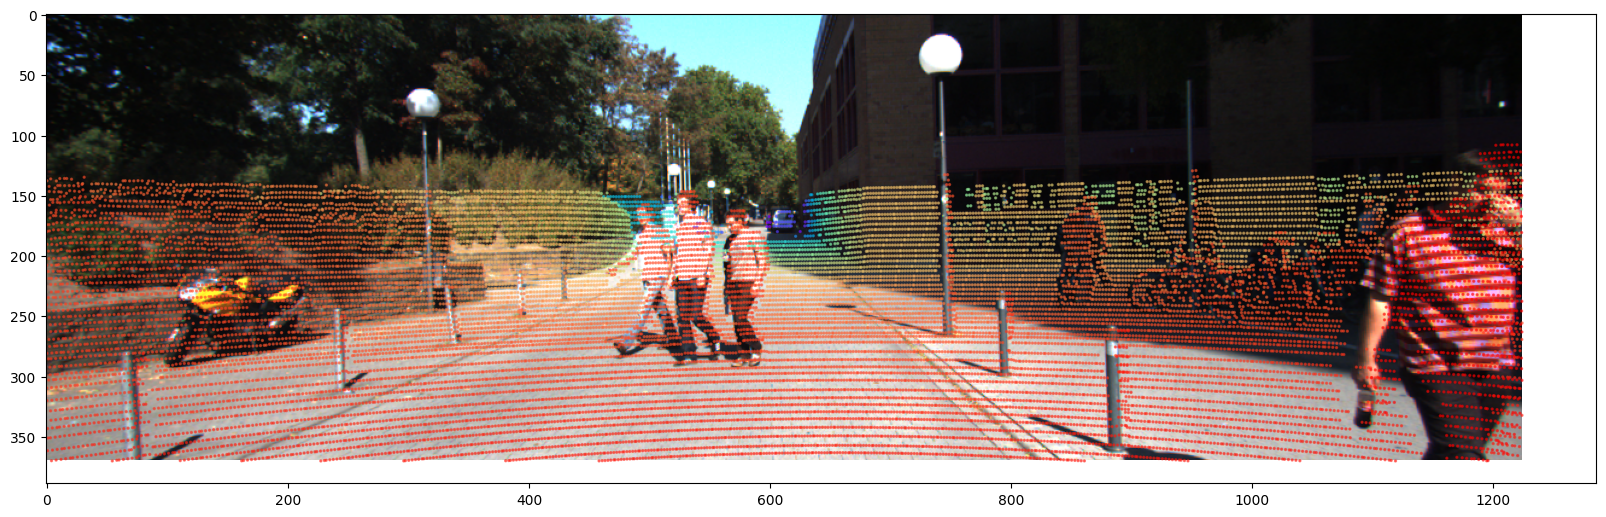

In [17]:
(u, v, z) = project_velo2cam(lidar_bin, left_image, remove_plane=False)

# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

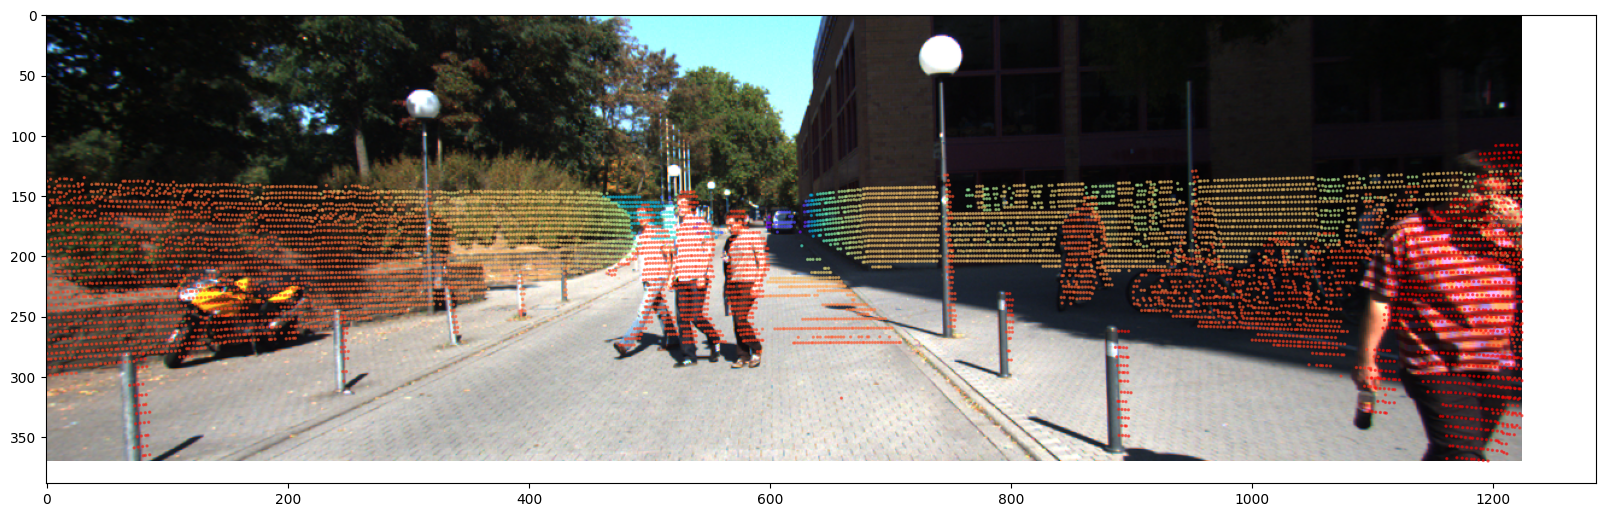

In [18]:
(u, v, z) = project_velo2cam(lidar_bin, left_image, remove_plane=True)

# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

## **Get Object Detection Pipeline**

Any object detector will work, we will use yolov5 to get the job done.

In [19]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [20]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [21]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-18 Python-3.10.12 torch-2.2.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 93.9MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [22]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## **Detection Pipeline**

Now we can define the main pipeline to get the detections and their center coordinates in multiple reference frames. We will get the object centers in:
- Camera (u, v, z)
- LiDAR (x, y, z)
- IMU (x, y, z)


The basic pipeline is:

1. Detect objects in camera image
2. Project LiDAR point cloud to camera (u,v,z) coordinates
3. Associate object centers with projected (u,v,z) points
4. Transform (u,v,z) objects centers to IMU (x,y,z) coordinates
5. Transform IMU (x,y,z) coordinates to Lat/Lon/Alt

In [23]:
def get_distances(image, velo_camera, bboxes, draw=True):
    ''' Obtains distance measurements for each detected object in the image
        Inputs:
          image - input image for detection
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each
                  bounding box
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[x_center, y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([u[min_loc], v[min_loc], velo_depth])

        # add velo (u, v, z) to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int),
                             np.round(x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 0, 0), 2, cv2.LINE_AA)

    return bboxes_out

In [24]:
def get_depth_detections(left_image, lidar_bin, draw_boxes=True,
                         draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo
        pair. The images are assumed to have already been rectified. Parameters
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    ## compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu()

    # get LiDAR points and transform them to image/camera space
    velo_camera = project_velo2cam(lidar_bin, left_image)

    # get distance measurements for image
    bboxes_out = get_distances(left_image,
                              velo_camera,
                              bboxes,
                              draw=draw_depth)

    return bboxes_out, velo_camera

## **Transform (u,v,z) objects centers to IMU (x,y,z) coordinates**

To transform the (u,v,z) object centers, we just convert them to homogeneous and use our homogeneous transformation to get the IMU (x,y,z) coordinates.

## **Convert IMU to LLA**
Now we need to convert the object IMU (x, y, z) coordinates to Azimuth, Elevation, and Range. Then we can use pymap3d to convert the object centers to Latitude, Longitude, and Altitude. TThe altitude the KITTI dataset does not specify what type of altitude, but the [OXTS documentation](https://www.oxts.com/wp-content/uploads/2020/03/rtman-200302.pdf) states that it can measure either geoidal (MSL) or ellipsoidal (HAE), for details see [this](https://support.pix4d.com/hc/en-us/articles/202559869-Orthometric-vs-ellipsoidal-height). We will go ahead and assume that altitude doesn't matter

In [25]:
!pip install pymap3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00


In [26]:
import pymap3d as pm


def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    ''' Converts cartesian IMU coordinates to Geodetic based on current
        location. This function works with x,y,z as vectors and lat0, lon0,
        alt0 as scalars.
        '''
    # convert to RAE (Range, Azimuth and Elevation)
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90

    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

In [27]:
def get_oxts(oxt_path):
    ''' Obtains the oxt info from a single oxt path '''
    with open(oxt_path) as f:
        oxts = f.readlines()

    oxts = oxts[0].strip().split(' ')
    oxts = np.array(oxts).astype(float)

    return oxts

In [28]:
def transform_uvz(uvz, T):
    ''' Transforms the distance coordinates to xyz coordinates. The xyz coordinate
        frame is specified by the transformation matrix T.'''

    # covnert to homogeneous representation
    uvzw = np.hstack((uvz[:, :2] * uvz[:, 2][:, None],
                      uvz[:, 2][:, None],
                      np.ones((len(uvz[:, :3]), 1))))

    # perform homogeneous transformation
    xyzw = T @ uvzw.T

    # get xyz coordinates
    xyz = xyzw[:3, :].T

    return xyz

In [29]:
from matplotlib import cm

# get color map function
rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

def draw_velo_on_image(velo_camera, velo_image, color_map=get_color):

    # unpack LiDAR points
    u, v, z = velo_camera

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        cv2.circle(velo_image, (int(u[i]), int(v[i])), 1,
                  color_map(z[i]), -1)

    return velo_image

<ipython-input-29-4594236a35ee>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow_r = cm.get_cmap('rainbow_r', lut=100)


## **Test the base pipeline**

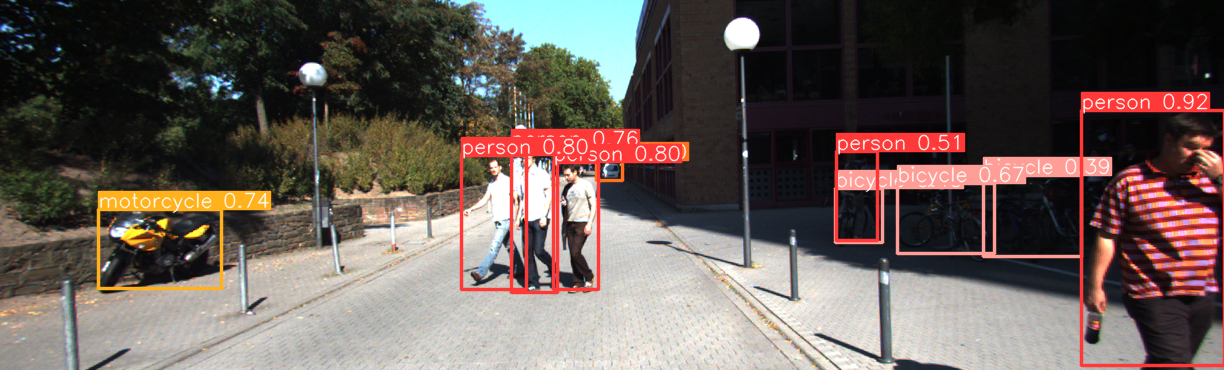

In [30]:
index = 75

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_camera = get_depth_detections(left_image, bin_path, draw_boxes=True,
                         draw_depth=True)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_cam_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [31]:
velo_image = draw_velo_on_image(velo_camera, np.zeros_like(left_image))

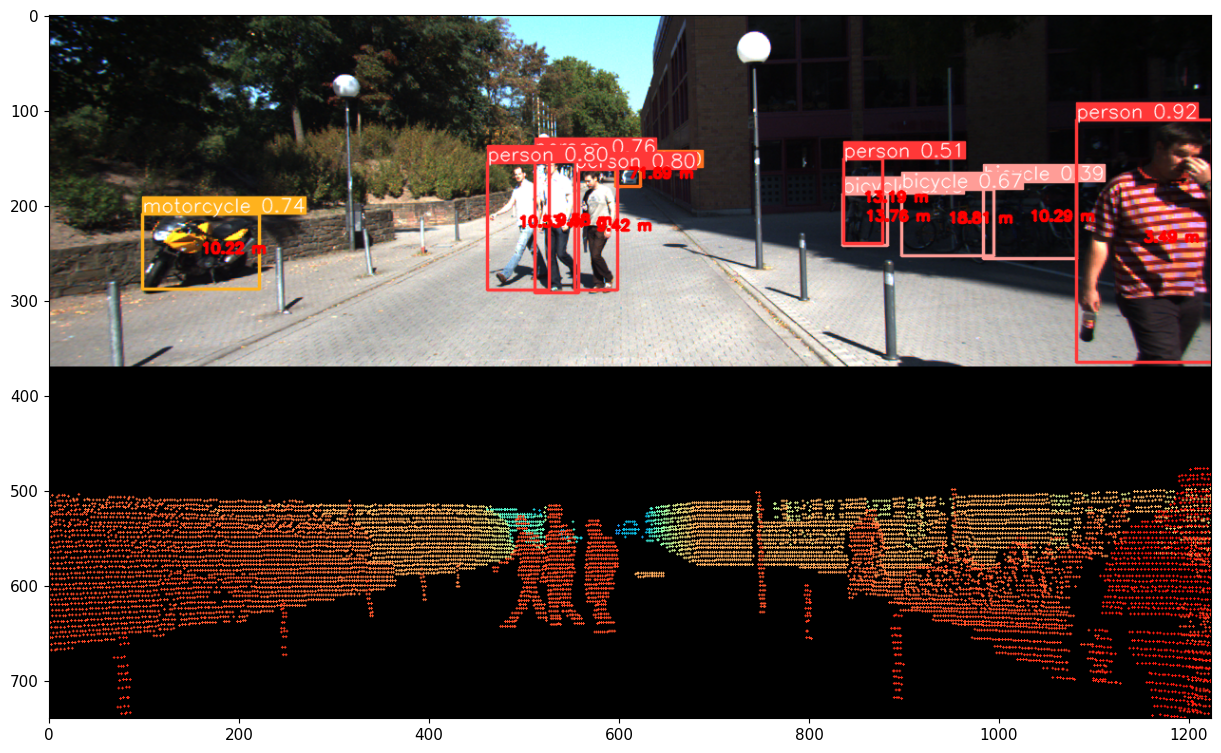

In [32]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked)
plt.show()

## **Lets move on to extracting 3D point cloud objects**

We will use DBSCAN to cluster the points in LiDAR space. We will then project each of the 3D LiDAR clusters into u,v image space. Then will we will reduce the amount of clusters via size and proximity to the detected objects. Then we will draw bounding boxes around the clusters in image space.

In [33]:
def image_clusters_from_velo(velo_points, labels, image):
    ''' Obtains clusters in image space from velo (LiDAR) points'''

    cam_clusters = {}
    for label in np.unique(labels):

        # convert from velo to camera
        velo_cam = velo2camera(velo_points[:, labels == label], image)

        # append cluster label and cluster to clusters
        if velo_cam.shape[1] > 0:
            cam_clusters.update({label : velo_cam})

    return cam_clusters

In [34]:
def draw_clusters_on_image(image, cluster_dict, draw_centroids=False):
    ''' draws the clusters on an image '''
    rainbow_r = cm.get_cmap('rainbow_r', lut=50)
    get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

    for label, cluster in cluster_dict.items():
        for (u, v, z) in cluster.T:
            cv2.circle(image, (int(u), int(v)), 1,
                       get_color(label), -1);

        if draw_centroids:
            centroid = np.mean(cluster, axis=1)
            cv2.circle(image, (int(centroid[0]), int(centroid[1])), 5,
                       get_color(label), -1);

    return image


## **Read LiDAR data directly from bin file**

Here we will cluster the objects in LiDAR space

In [35]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

##  **Use DBSCAN to cluster points**

In [36]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.5, min_samples=30)
dbscan.fit(velo_points[:3, :].T)

DBSCAN(min_samples=30)

In [37]:
labels = dbscan.labels_
cam_clusters = image_clusters_from_velo(velo_points, labels, left_image)

In [38]:
new_image = np.zeros_like(left_image)
new_image = draw_clusters_on_image(new_image, cam_clusters, draw_centroids=True)

<ipython-input-34-69a023dbddad>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow_r = cm.get_cmap('rainbow_r', lut=50)


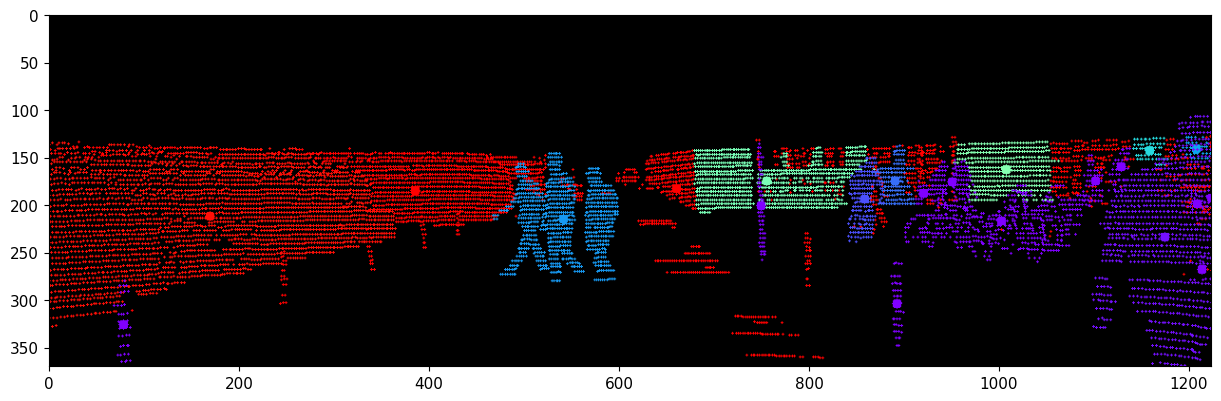

In [39]:
plt.imshow(new_image)

## **Create pipeline to place 3D bounding boxes on object**

DBSCAN seems to work well. Now we need to associate the LiDAR clusters with the detected objects. The initial approach that I took was to use the Hungarian Algorithm to do the matching, but I couldn't get any decent results. So instead I chose to fuse the data in the camera space by determining if the cluster centroid was close enough to the detected object (u,v,z) center. This is an inutitive approach and works well enough. However it does not make a good use of the detected objects, we could almost perform this whole pipeline unsupervised and not have to do any detections

In [40]:
from sklearn.cluster import DBSCAN

def get_clusters(velo_points):
    dbscan = DBSCAN(eps=0.5, min_samples=30)
    dbscan.fit(velo_points[:3, :].T)

    labels = dbscan.labels_

    return dbscan, labels

In [41]:
def get_likely_clusters(cluster_dict, object_centers, min_thresh=50, thresh=75):
    ''' Obtains more likely clusters '''

    new_clusters = {}
    noise_cluster = cluster_dict[-1]

    labels = sorted(cluster_dict)

    for label in labels:
        cluster = cluster_dict[label]

        if cluster.shape[1] > min_thresh \
           and cluster.shape[1] < noise_cluster.shape[1] //2:

            # ensure centroid has correct order
            centroid = np.mean(cluster, axis=1)[[1, 0, 2]]

            # check if any objects are detected
            if len(object_centers) > 0:
                delta = np.linalg.norm(centroid - object_centers, axis=1)
                min_loc = np.argmin(delta)

                if delta[min_loc] < thresh:
                    new_clusters.update({label : cluster})

            else:
                new_clusters.update({label : cluster})

    return new_clusters

In [42]:
def get_3d_bboxes(cluster_dict, labels, velo_points):
    camera_box_point_list = []

    for c_label, cluster in cluster_dict.items():

        velo_cluster = velo_points[:3, labels == c_label]

        (x_min, y_min, z_min) = velo_cluster.min(axis=1)
        (x_max, y_max, z_max) = velo_cluster.max(axis=1)

        # now get points to define 3d bounding box
        # box_points = np.array([[x_max, y_max, z_max]]) * arr
        # we will just manually do this for now
        box_points = np.array([
            [x_max, y_max, z_max, 1],
            [x_max, y_max, z_min, 1],
            [x_max, y_min, z_max, 1],
            [x_max, y_min, z_min, 1],
            [x_min, y_max, z_max, 1],
            [x_min, y_max, z_min, 1],
            [x_min, y_min, z_max, 1],
            [x_min, y_min, z_min, 1]
        ])

        # convert these box points to image space
        camera_box_points = T_mat @ box_points.T
        camera_box_points[:2] /= camera_box_points[2, :]

        camera_box_points = camera_box_points.round().T.astype(int)

        # append to list
        camera_box_point_list.append(camera_box_points)

    return camera_box_point_list

In [43]:
pastel = cm.get_cmap('Pastel2', lut=50)
get_pastel = lambda z : [255*val for val in pastel(z)[:3]]

def draw_3d_boxes(image, camera_box_points):
    for i, box_pts in enumerate(camera_box_points):
        [A, B, C, D, E, F, G, H] = box_pts[:, :2]
        color = get_pastel(i)

        # draw rear box (X-axis is forward for LiDAR)
        cv2.line(image, A, B, color, 2)
        cv2.line(image, B, D, color, 2)
        cv2.line(image, A, C, color, 2)
        cv2.line(image, D, C, color, 2)

        # draw front box
        cv2.line(image, G, E, color, 2)
        cv2.line(image, H, F, color, 2)
        cv2.line(image, G, H, color, 2)
        cv2.line(image, E, F, color, 2)

        # draw sides
        cv2.line(image, E, A, color, 2)
        cv2.line(image, G, C, color, 2)
        cv2.line(image, F, B, color, 2)
        cv2.line(image, H, D, color, 2)

    return image

<ipython-input-43-f3f4a742d5dd>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel = cm.get_cmap('Pastel2', lut=50)


In [44]:
def get_distances1(detections, image, velo_camera, bboxes, draw=True):
    ''' Obtains distance measurements for each detected object in the image '''

    # Get the class names and bounding box coordinates
    class_names = detections.names
    detected_classes = [int(cls) for cls in detections.pred[0][:, -1]]
    boxes = detections.pred[0][:, :4]


    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[x_center, y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([u[min_loc], v[min_loc],velo_depth])

        # add velo (u, v, z) to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int),
                             np.round(x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 0, 0), 2, cv2.LINE_AA)

            # draw the class name above the depth information
            class_name = class_names[detected_classes[i]]   # Get the class name for the current bbox
            class_position = (object_center[0], object_center[1] - 15)  # Position above the depth
            cv2.putText(image, class_name, class_position,
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    return bboxes_out

In [45]:
def get_distances2(detections, image, velo_camera, bboxes, draw=True):
    ''' Obtains distance measurements for each detected object in the image '''

    # Get the class names and bounding box coordinates
    class_names = detections.names
    detected_classes = [int(cls) for cls in detections.pred[0][:, -1]]
    boxes = detections.pred[0][:, :4]


    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[x_center, y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([v[min_loc], u[min_loc],velo_depth])

        # add velo (u, v, z) to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int),
                             np.round(x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 0, 0), 2, cv2.LINE_AA)

            # draw the class name above the depth information
            class_name = class_names[detected_classes[i]]   # Get the class name for the current bbox
            class_position = (object_center[0], object_center[1] - 15)  # Position above the depth
            cv2.putText(image, class_name, class_position,
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    return bboxes_out

In [46]:
def get_depth_detections1(left_image, lidar_bin, draw_boxes=True,
                         draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo
        pair. The images are assumed to have already been rectified. Parameters
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    # compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu()

    # get LiDAR points and transform them to image/camera space
    velo_camera = project_velo2cam(lidar_bin, left_image)

    # get distance measurements for image
    bboxes_out1 = get_distances1(detections, left_image,
                                           velo_camera,
                                           bboxes,
                                           draw=draw_depth)

    bboxes_out2 = get_distances2(detections, left_image,
                                           velo_camera,
                                           bboxes,
                                           draw=draw_depth)
    return bboxes_out1, bboxes_out2, velo_camera

## **Test the pipeline on an image**

In [47]:
index = 75

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

velo_points = bin2h_velo(lidar_bin, remove_plane=True)

In [48]:
def main_pipeline(left_image, lidar_bin, velo_points):
    # get object detections
    bboxes_out1, bboxes_out2, velo_camera = get_depth_detections1(left_image,
                                                           lidar_bin,
                                                           draw_boxes=False,
                                                           draw_depth=True)

    # get transformed coordinates of object centers
    uvz = bboxes_out1[:, -3:]

    # transform to (u,v,z)
    # velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
    imu_xyz = transform_uvz(uvz, T_cam_imu)

    # get Lat/Lon on each detected object
    lat0 = oxts_frame[0]
    lon0 = oxts_frame[1]
    alt0 = oxts_frame[2]
    heading0 = oxts_frame[5]

    lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

    # perform clustering in LiDAR space
    dbscan, labels = get_clusters(velo_points)


    # get clusters in image space
    cam_clusters = image_clusters_from_velo(velo_points, labels, left_image)

    # get object centers in camera (u, v, z) coordinates
    object_centers = bboxes_out2[:, 6:]

    # remove small and large clusters also remove cluster far away from detected objects
    cam_clusters = get_likely_clusters(cam_clusters, object_centers, min_thresh=50, thresh=75)

    # get 3D bbox points in camera space from clusters
    camera_box_points = get_3d_bboxes(cam_clusters, labels, velo_points)

    # draw 3D bounding boxes on the image
    left_image = draw_3d_boxes(left_image, camera_box_points)

    return uvz, imu_xyz, lla, left_image, cam_clusters

<ipython-input-34-69a023dbddad>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow_r = cm.get_cmap('rainbow_r', lut=50)


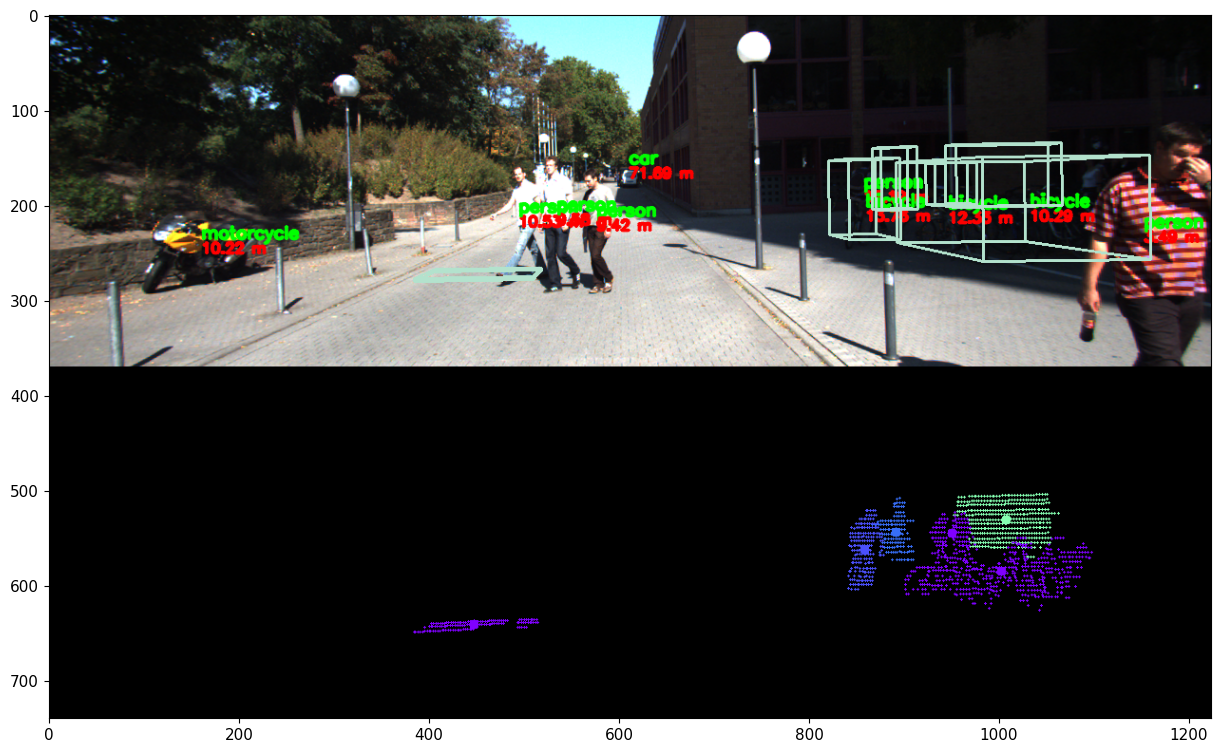

In [49]:
# run pipeline
uvz, imu_xyz, lla, left_image, cam_clusters = main_pipeline(left_image, lidar_bin, velo_points)

# draw projected clusters on new image
cluster_image = np.zeros_like(left_image)
cluster_image = draw_clusters_on_image(cluster_image, cam_clusters, draw_centroids=True)

stacked = np.vstack((left_image, cluster_image))

plt.imshow(stacked)

Now that we have locations for each object from IMU data we can recontsruct the scene at each frame, using the LLA locations.

In [50]:
!pip install folium

In [51]:
import folium

drive_map = folium.Map(
    location=(lat0, lon0), # starting location
    zoom_start=18
)

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [52]:
# place the position of each detection on the map
for pos in lla:
    folium.CircleMarker(location=(pos[0], pos[1]),
                        radius=2,
                        weight=5,
                        color='green').add_to(drive_map);

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [53]:
drive_map

Now we can use opencv2 to display the environment detected by the Camera and LiDAR. In this case we will draw a rectangle for every detected object, but we can use the detected MSCOCO class in bboxes and draw custom symbols for each different object. We can also cluster the data in LiDAR space and draw sybols based on the clustered data shape.

In [54]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);


    return canvas

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
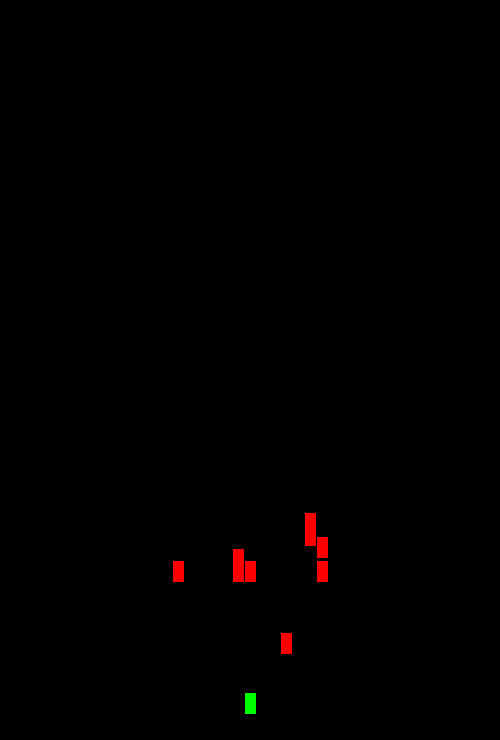

In [55]:
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
draw_scenario(canvas, imu_xyz, sf=12)

Now we stack all of the images together into a single frame!

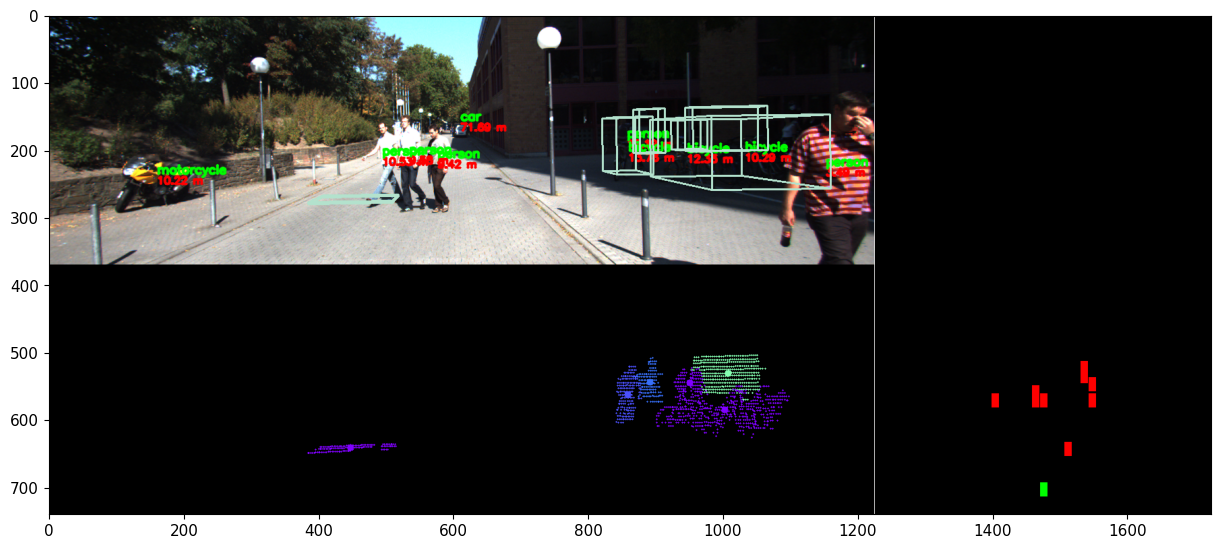

In [56]:
frame = np.hstack((stacked,
                  255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                  canvas))

plt.imshow(frame)

## **Now let's use this pipeline to create a video**

Now we can make a video of our results, but first let's get the average frame rate from the left camera time stamps.

In [57]:
get_total_seconds = lambda hms: hms[0]*60*60 + hms[1]*60 + hms[2]


def timestamps2seconds(timestamp_path):
    ''' Reads in timestamp path and returns total seconds (does not account for day rollover '''
    df = pd.read_csv(timestamp_path,
                             header=None)

    timestamps = df.squeeze('columns').astype(str).apply(lambda x: x.split(' ')[1])

    # Get Hours, Minutes, and Seconds
    hours = timestamps.apply(lambda x: x.split(':')[0]).astype(np.float64)
    minutes = timestamps.apply(lambda x: x.split(':')[1]).astype(np.float64)
    seconds = timestamps.apply(lambda x: x.split(':')[2]).astype(np.float64)

    hms_vals = np.vstack((hours, minutes, seconds)).T

    total_seconds = np.array(list(map(get_total_seconds, hms_vals)))

    return total_seconds


In [58]:
cam2_total_seconds = timestamps2seconds(os.path.join(DATA_PATH, r'image_02/timestamps.txt'))

In [59]:
# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

9.649207313917676

In [60]:
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]
    oxts_frame = get_oxts(oxts_paths[idx])

    # read in raw velo points
    velo_points = bin2h_velo(lidar_bin, remove_plane=True) # possibly RANSAC the walls too

    # run pipeline
    uvz, imu_xyz, lla, left_image, cam_clusters = main_pipeline(left_image, lidar_bin, velo_points)

    # draw projected clusters on new image
    cluster_image = np.zeros_like(left_image)
    cluster_image = draw_clusters_on_image(cluster_image, cam_clusters, draw_centroids=True)

    # stack frames
    stacked = np.vstack((left_image, cluster_image))

    # draw top down scenario on canvas
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    draw_scenario(canvas, imu_xyz, sf=12)

    # place everything in a single frame
    frame = np.hstack((stacked,
                       255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                       canvas))

    # add to result video
    result_video.append(frame)

# get width and height for video frames
h, w, _ = frame.shape

out = cv2.VideoWriter('Lidar_Demo_Final.mp4',cv2.VideoWriter_fourcc(*'MP4V'), cam2_fps, (w,h))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

<ipython-input-34-69a023dbddad>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow_r = cm.get_cmap('rainbow_r', lut=50)
<ipython-input-34-69a023dbddad>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow_r = cm.get_cmap('rainbow_r', lut=50)
<ipython-input-34-69a023dbddad>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rainbow_r = cm.get_cmap('rainbow_r', lut=50)
<ipython-input-34-69a023dbddad>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated i